In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import StackingRegressor, HistGradientBoostingRegressor
import xgboost as xgb

import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

In [2]:
try:
    import lightgbm as lgb
    use_lgb = True
except ImportError:
    use_lgb = False


In [3]:
df = pd.read_csv("corn_growth_dataset.csv")


In [4]:
X = df.drop("PlantHeight(cm)", axis=1)
y = df["PlantHeight(cm)"]


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Extra Trees": ExtraTreesRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "AdaBoost": AdaBoostRegressor(),
    "KNN": KNeighborsRegressor(),
    "SVR": SVR(),
    "XGBoost": xgb.XGBRegressor(),
    "MLP Regressor": MLPRegressor(hidden_layer_sizes=(64, 64), max_iter=1000),
    "HistGradientBoosting": HistGradientBoostingRegressor()
}

In [9]:
if use_lgb:
    models["LightGBM"] = lgb.LGBMRegressor()


stack = StackingRegressor(
    estimators=[
        ('ridge', Ridge()),
        ('svr', SVR()),
        ('gb', GradientBoostingRegressor())
    ],
    final_estimator=LinearRegression()
)
models["Stacking"] = stack

In [10]:
results = []
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((name, mae, mse, r2))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 3
[LightGBM] [Info] Start training from score 54.814664


In [11]:
results_df = pd.DataFrame(results, columns=["Model", "MAE", "MSE", "R2_Score"]).sort_values(by="R2_Score", ascending=False)
results_df.reset_index(drop=True, inplace=True)
print(results_df)

results_df.to_csv("advanced_model_comparison.csv", index=False)  

                   Model       MAE        MSE  R2_Score
0               Stacking  3.979336  24.850537  0.827383
1                  Ridge  3.980430  24.855255  0.827350
2      Linear Regression  3.980430  24.855278  0.827350
3                    SVR  4.001863  25.047680  0.826014
4          MLP Regressor  3.997727  25.061441  0.825918
5      Gradient Boosting  4.042373  25.626745  0.821992
6   HistGradientBoosting  4.066389  25.878908  0.820240
7               LightGBM  4.075725  25.890195  0.820162
8                  Lasso  4.224323  27.717050  0.807472
9                XGBoost  4.220143  27.808212  0.806839
10         Random Forest  4.293124  28.758668  0.800237
11              AdaBoost  4.332265  29.287760  0.796561
12           Extra Trees  4.361104  29.928294  0.792112
13                   KNN  4.406605  30.405299  0.788799
14            ElasticNet  5.250887  42.531638  0.704567
15         Decision Tree  5.840052  53.627582  0.627492


In [12]:
# Show predictions from the best model (Stacking)
best_model = models["Stacking"]
y_pred_best = best_model.predict(X_test_scaled)

# Create a DataFrame comparing actual vs predicted values
comparison_df = pd.DataFrame({
    "Actual Height (cm)": y_test.values,
    "Predicted Height (cm)": y_pred_best
})

# Show first 10 comparisons
print(comparison_df.head(10))


   Actual Height (cm)  Predicted Height (cm)
0           35.553041              36.529133
1           41.788541              48.908274
2           65.480704              70.739607
3           55.616416              52.380774
4           86.256793              76.156257
5           48.924387              47.587459
6           55.737435              54.006660
7           54.083102              56.768651
8           61.492113              63.910974
9           86.052505              78.859292


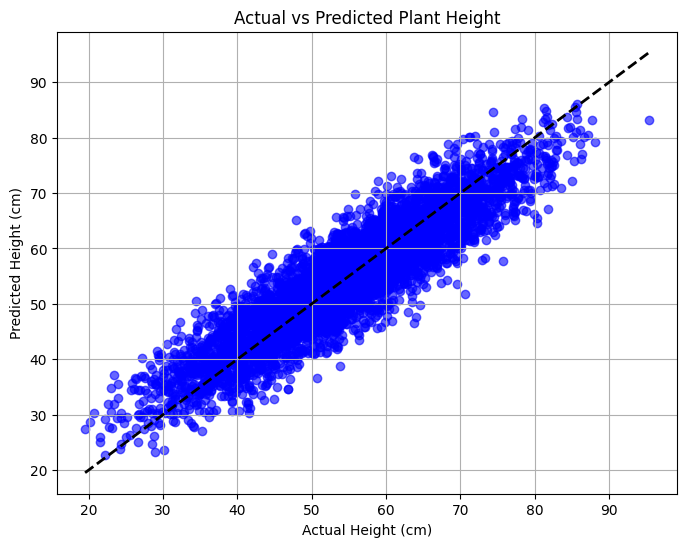

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_best, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual Height (cm)")
plt.ylabel("Predicted Height (cm)")
plt.title("Actual vs Predicted Plant Height")
plt.grid(True)
plt.show()


In [ ]:
import serial
import time

# Setup serial connection (adjust COM port and baud rate as per your ESP32 config)
ser = serial.Serial('COM3', 115200, timeout=5)  # Change COM3 to your port, and baud rate accordingly
time.sleep(2)  # Wait for connection to stabilize

def read_sensor_and_predict():
    try:
        if ser.in_waiting > 0:
            line = ser.readline().decode('utf-8').strip()
            # Assuming ESP32 sends: "temp,humidity,moisture" like "28.3,65.2,42.5"
            temp, humidity, soil_moisture = map(float, line.split(','))
            prediction = predict_height_from_sensors(temp, humidity, soil_moisture)
            print(f"Temperature: {temp}°C, Humidity: {humidity}%, Soil Moisture: {soil_moisture}%")
            print(f"📏 Predicted Plant Height: {prediction:.2f} cm\n")
    except Exception as e:
        print(f"Error reading from ESP32: {e}")

# Example loop to read 10 times
for _ in range(10):
    read_sensor_and_predict()
    time.sleep(2)  # Wait between readings


ModuleNotFoundError: No module named 'serial'